In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def read_slopes(filename):
    df = pd.read_csv(
        filename,
        sep='\t',
        header=None,
        names=['time', 'date', 'barcode', 'temp', 'curr_low', 'curr_high', 't_wait', 't_sample', 'slope', 'status', 'flow', 'flow2']
    )
    df = df.filter(['barcode', 'flow', 'slope'])
    return df

In [10]:
df = read_slopes('Raw_Data_ALIMCH_61.xls')

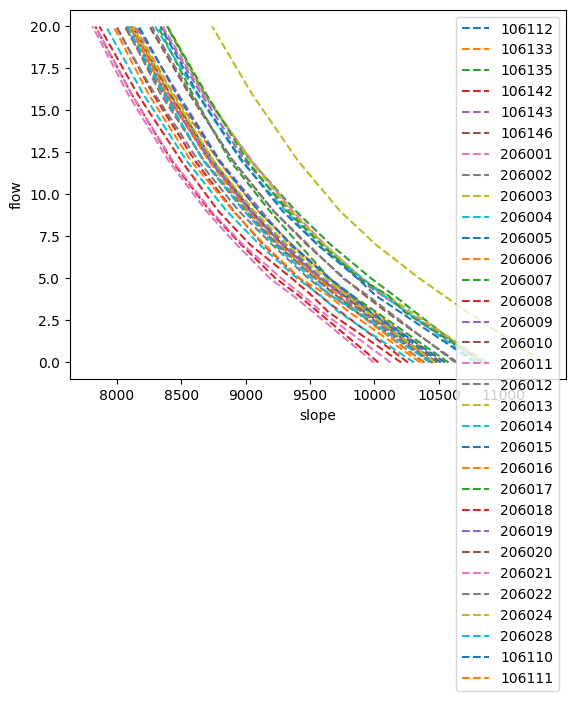

In [11]:
barcodes = [b for b in set(df['barcode'])]
for barcode in barcodes:
    df_sel = df[df.barcode == barcode]
    
    plt.plot(df_sel['slope'], df_sel['flow'], '--')
plt.xlabel('slope')
plt.ylabel('flow')
plt.legend(barcodes)

plt.show()

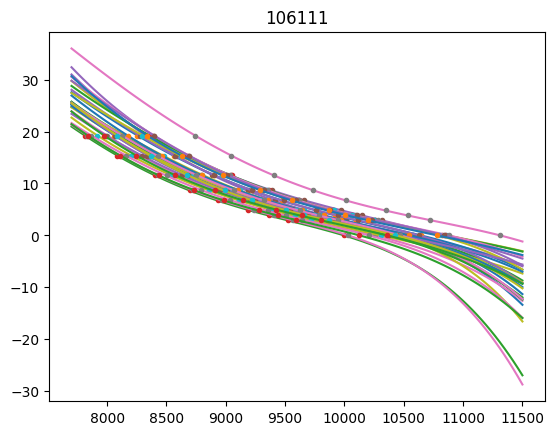

In [12]:
calib_params = dict() # Dict mapping barcode onto calibration params
for barcode in set(df['barcode']):
    df_sel = df[df.barcode == barcode]

    flows_corrected = [v*0.9621 for v in df_sel['flow']] # Correction since 85Ar 15CO2 was used
    
    params = np.polynomial.polynomial.polyfit(df_sel['slope'], flows_corrected, 4)
    calib_params[barcode] = params
    # xx = np.linspace(min(df_sel['slope']), max(df_sel['slope']), 100)
    xx =  np.linspace(7700, 11500, 100)
    yy = [np.dot(params, [1, x, x**2, x**3, x**4]) for x in xx]
    plt.plot(xx, yy)
    
    plt.plot(df_sel['slope'], flows_corrected, '.')
    plt.title(barcode)
    
    # plt.show()

In [13]:
def slope_to_flow(barcode, slope):
    params = calib_params[barcode]
    x = slope
    return np.dot(params, [1, x, x**2, x**3, x**4])

def flow_to_slope(barcode, flow):
    slope_min = 7700.
    slope_max = 11500.
    
    flow_mid = -1
    while abs(flow_mid-flow) > 0.01:
    
        slope_mid = (slope_min+slope_max)/2
        flow_mid = slope_to_flow(barcode, slope_mid)
        
        if flow_mid < flow:
            slope_max = slope_mid
        else:
            slope_min = slope_mid
        
    return slope_mid
    

In [14]:
b = 206006
print(flow_to_slope(b, slope_to_flow(b, 9500)))

9499.8046875
